# Creating Data 

In [2]:
import pandas as pd
import statsmodels.datasets.co2 as co2
import matplotlib.pyplot as plt

In [3]:
co2_data = co2.load().data
print(co2_data)

print(co2_data['co2'].max())
print(co2_data['co2'].min())
print(co2_data['co2'].max() - co2_data['co2'].min())


              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4
...           ...
2001-12-01  370.3
2001-12-08  370.8
2001-12-15  371.2
2001-12-22  371.3
2001-12-29  371.5

[2284 rows x 1 columns]
373.9
313.0
60.89999999999998


Um Daten zu haben, welche repräsentativ für die Messdaten stehen, werden daten heruntergeladen, die dann auf mögliche Messdaten für ein Fahrzeug angepasst werden. Da die Seminararbeit und dieser dazugehörige Code für eine Vorstellung von Vorgehen genutzt wird, werden Daten genommen, bei denen bekannt ist, dass sie betimmte Muster vorweisen. 

In [4]:
 
co2_data['co2_adjusted'] = co2_data['co2'] - co2_data['co2'].min()
car_data = co2_data['co2_adjusted']

car_data = car_data.rename('geschwindigkeit')


car_data.index = pd.date_range(start='2022-01-01', periods=len(car_data), freq='1s')
car_data_random_forest = car_data.copy()
car_data_random_forest.index  = pd.date_range(start='2022-01-01', periods=len(car_data), freq='1s')

car_data.index =  (car_data.index.astype('int64') // 10**9).astype('int32')

print(car_data)



1640995200     3.1
1640995201     4.3
1640995202     4.6
1640995203     4.5
1640995204     3.4
              ... 
1640997479    57.3
1640997480    57.8
1640997481    58.2
1640997482    58.3
1640997483    58.5
Name: geschwindigkeit, Length: 2284, dtype: float64


Bei der Anpassungen der Daten, wurde nur die Differnez der vorherigen Daten verwendet, damit Werte gewonnen werden, welche eher zu einer Geschwindigkeit eines Autos passt. Damit die Abstände der Wert auch keine Tage sind, wurde der Abstand der Einträge auf 1 Sekunde gesetzt.
Für die weitern Schritte wird angenommen, dass aus der Tabelle Messung die Messdaten eines Fahrzeugs entnommen wurden und weiter untersucht werden. Der Timestep wurde dafür auch in das Unix Timestemp-Format umgewandelt. 

# Maschinelles Lernen mit Zeitreihen

## Datenvorbereitung

In [5]:
car_data.index = car_data.index - car_data.index.min()
car_data

0        3.1
1        4.3
2        4.6
3        4.5
4        3.4
        ... 
2279    57.3
2280    57.8
2281    58.2
2282    58.3
2283    58.5
Name: geschwindigkeit, Length: 2284, dtype: float64

Um ein besseres zeitliches Verständis zu erhalten, werden von der Zeitangabe der min-Wert abgezogen. Dadurch ist angeben wie viele Sekunden vergangen sind wann der Wert aufgenommen wurde.

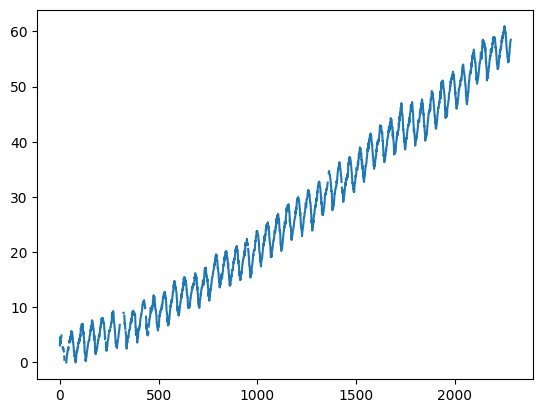

In [8]:
car_data.plot()
plt.savefig('pictures/Datenvorbereitung/car_data_NaN.pdf')
plt.show()

Werde die Daten in einem Graphen dargestellt, ist sichtbar, dass Lücken in dem Graphen vorliegen, welche mit Werten ersetzt werden müssen.

In [9]:
# anzahl der Nan Werte
print("Es liegen folgende Anzahl Nan-Werte vor:")
print(car_data.isna().sum())

Es liegen folgende Anzahl Nan-Werte vor:
59


In [10]:
car_data = car_data.fillna(car_data.interpolate())
car_data_random_forest = car_data_random_forest.fillna(car_data_random_forest.interpolate())

Wie in der Seminararbeit auch beschrieben, können diese Werte nicht einfach mit Durchschnittswerten ersetzt werden. Aus diesem Grund wird die Funktion interpolate benutzt um die NaN-Werte aufzufüllen. Dabei werden zweibekannte Datenpunkte mit einer geraden Linie verbindet und der Wert an einem Zwischenpunkt durch einfache lineare Gleichungen geschätzt.

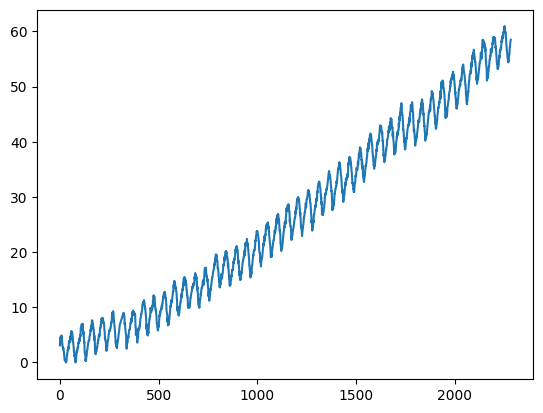

In [11]:
car_data.plot()
plt.savefig('pictures/Datenvorbereitung/car_data_ohneNaN.pdf')
plt.show()

In [12]:
# anzahl der Nan Werte
print("Es liegen folgende Anzahl Nan-Werte vor:")
print(car_data.isna().sum())

Es liegen folgende Anzahl Nan-Werte vor:
0


## Datenanalyse

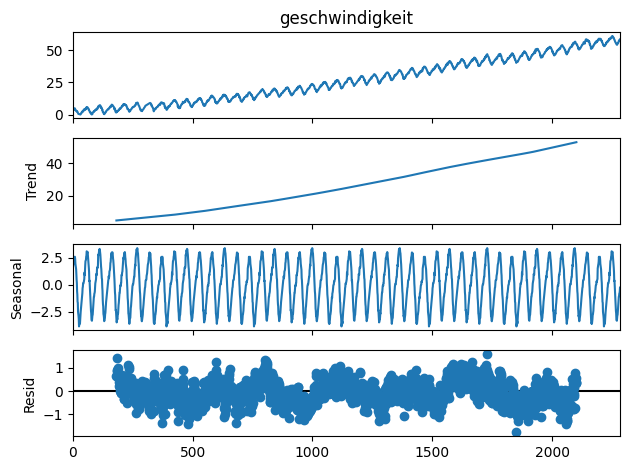

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(car_data, model='additive', period=365)
result.plot()
# export the plot as pdf
plt.savefig('pictures/Datenanalyse/seasonal_decompose.pdf')
plt.show()

In folgende Graphen sind die bereits in der Seminarabeit angesprochenen drei Komponenten der Zeitreihen zu sehen. Trend, Seasonality und Residual.

Es ist zu sehen, dass sowohl ein Trend als auch eine Seasonality in den Daten vorliegt. Es liegen zudem aber auch Residual Werte vor, welche nicht dirket klassifiziert werden konnten.

In [15]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(car_data.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: 0.03378459745816527
ADF p-values: 0.961238452828603
ADF number of lags used: 27
ADF number of observations: 2256
ADF critical values: {'1%': -3.4332519309441296, '5%': -2.8628219967376647, '10%': -2.567452466810334}
ADF best information criterion: 2578.39090925253


Mit dem diesem Test kann nachgeprüft werden, ob die Zeitreihendaten stationähr sind. Der Wert für test und p-Wert sind beides Werte die auf keine stationähre Daten hinweisen. Das Ergbnis ist auch zu erwarten, da in dem vorherigen Graphen bereits ein Trend zu erkennen war.

## Modellierung

### ARIMA

In [16]:
car_data_ARIMA = car_data[:600]

Die Daten für ARIMA mussten auf 600 verringert wurden, da die Daten sonst zu viele waren und nicht von meinem Rechner verarbeitet werden konnten.

In [17]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


train, test = train_test_split(car_data_ARIMA, train_size=0.8)
print(train.shape)
print(test.shape)

model = pm.auto_arima(train, seasonal=True, m=52)


(480,)
(120,)


Die Daten werden in train und test Daten unterteilt und das Model mit den Daten trainiert.

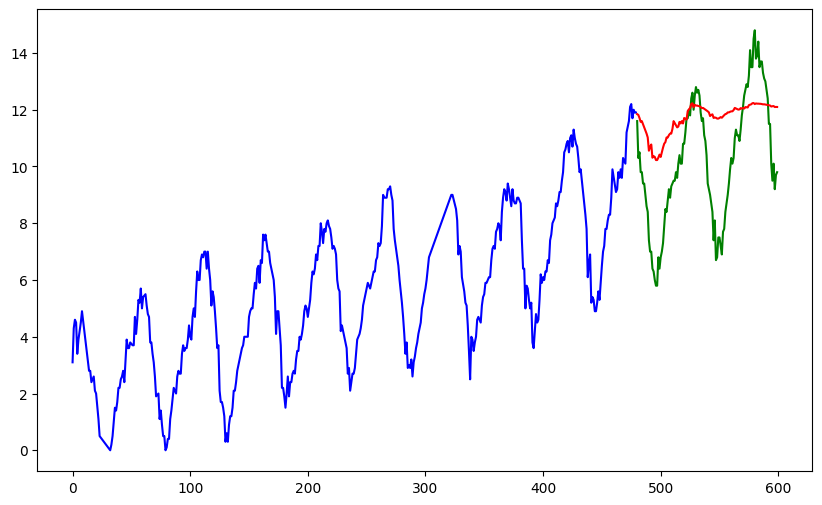

In [18]:
forecast = model.predict(test.shape[0])
plt.figure(figsize=(10, 6)) 
plt.plot(np.arange(train.shape[0]), train, color='blue')
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), test, color='green')
plt.plot(np.arange(train.shape[0], train.shape[0] + test.shape[0]), forecast, color='red')
plt.savefig('pictures/Modellierung/ARIMA.pdf')
plt.show()

Das Model wird nun genutzt um die test Daten vorherzusagen. In blau sind hierbei die Werte zu sehen, welche für das Training verwendet wurden. In grün sind die tatsächlichen Werte, welche Vorhergesagt werden sollten. In rot sind die vorhergesagten Werte zu sehen. 

Betrachtet man die Werte ist auf jeden Fall zu sehen, dass die Werte wachsen wie es vom Trend zu erwarten ist, jedoch weichen sie dennoch stark von den tatsächlichen Werten ab.

## Random forest

In [19]:
import numpy as np


seconds = [x.total_seconds() for x in car_data_random_forest.index - car_data_random_forest.index[0]]
ten_seconds = [x.total_seconds() / 10 for x in car_data_random_forest.index - car_data_random_forest.index[0]]
minutes = [x.total_seconds() / 60 for x in car_data_random_forest.index - car_data_random_forest.index[0]]

X = np.array([seconds, ten_seconds, minutes]).T
len(X)

2284

In [20]:
car_data_random_forest_train = car_data_random_forest[:2000]
len(car_data_random_forest_train)

2000

2000 Werte werden für das Trainging verwendet

In [21]:
import numpy as np



seconds = [x.total_seconds() for x in car_data_random_forest_train.index - car_data_random_forest_train.index[0]]
ten_seconds = [x.total_seconds() / 10 for x in car_data_random_forest_train.index - car_data_random_forest_train.index[0]]
minutes = [x.total_seconds() / 60 for x in car_data_random_forest_train.index - car_data_random_forest_train.index[0]]

X_train = np.array([seconds, ten_seconds, minutes]).T
print(len(X_train))


seconds = [x.total_seconds() for x in car_data_random_forest.index - car_data_random_forest.index[0]]
ten_seconds = [x.total_seconds() / 10 for x in car_data_random_forest.index - car_data_random_forest.index[0]]
minutes = [x.total_seconds() / 60 for x in car_data_random_forest.index - car_data_random_forest.index[0]]

X_pred = np.array([seconds, ten_seconds, minutes]).T
print(len(X_pred))


2000
2284


In [404]:
X_pred

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e-01, 1.66666667e-02],
       [2.00000000e+00, 2.00000000e-01, 3.33333333e-02],
       ...,
       [2.28100000e+03, 2.28100000e+02, 3.80166667e+01],
       [2.28200000e+03, 2.28200000e+02, 3.80333333e+01],
       [2.28300000e+03, 2.28300000e+02, 3.80500000e+01]])

Da RandomForest, normalerweise nicht mit Zeitreihen umgehen muss, müssen die Daten über features dem Model überbracht werden. In dem Fall werden die Zeitwerte als variablen übernommen und auf dieser Basis trainiert.

### Lineare Regression

Bevor mit dem Random Forest gestartet wird, wird eine Lineare Regression durchgeführt um auch diese einmal zu zeigen.

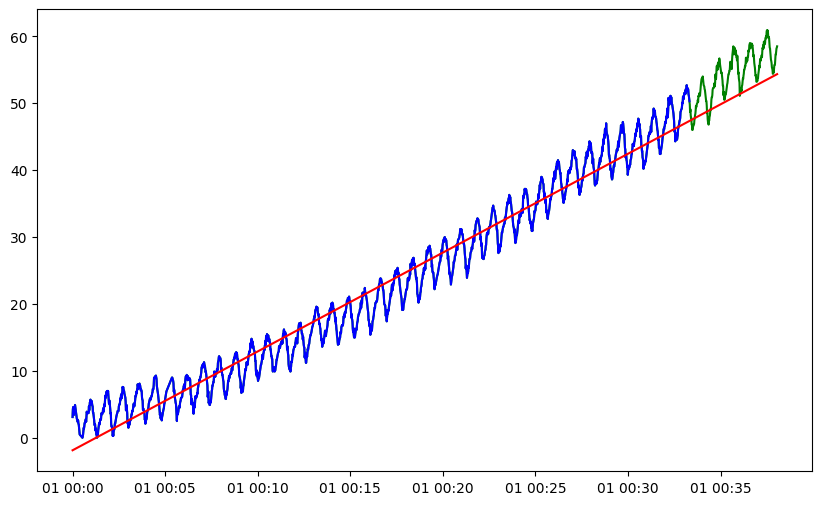

In [405]:
from sklearn.linear_model import LinearRegression

# Model erstellen
model = LinearRegression()
model.fit(X_train, car_data_random_forest_train.values)

# Vorhersage
preds = model.predict(X_pred)

# Plot
plt.figure(figsize=(10, 6)) 
plt.plot(car_data_random_forest.index, car_data.values, color='green')
plt.plot(car_data_random_forest_train.index, car_data_random_forest_train.values , color='blue')
plt.plot(car_data_random_forest.index, preds , color='red')

Auch hier sind in blau wieder die train Daten und in grün die test Daten. In diesem Fall wird jedoch über den gesamten Graph die Werte vorhergesagt. Es ist zu sehen, dass sich die Regression relativ gut an die Kurve anpasst.

### Random Forest

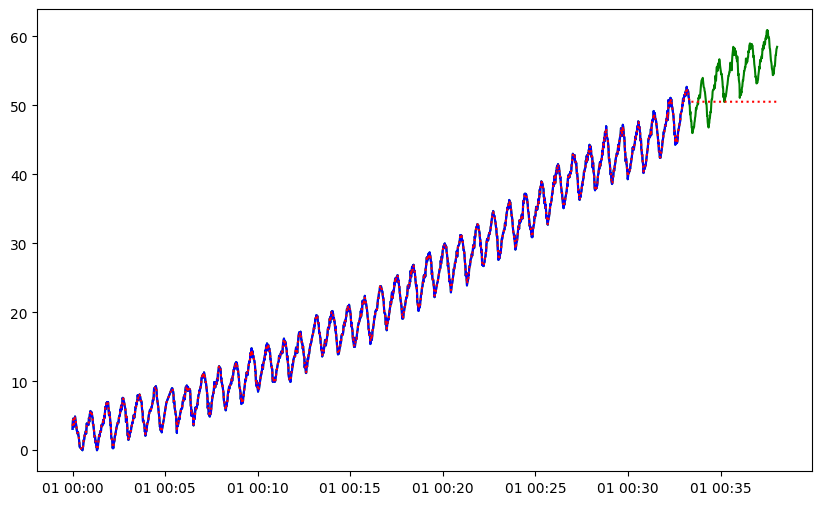

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Model erstellen
model = RandomForestRegressor()
train, test = train_test_split(car_data_random_forest.values, train_size=2200)
model.fit(X_train, car_data_random_forest_train.values)

# Vorhersage
preds = model.predict(X_pred)

# Plot
plt.figure(figsize=(10, 6)) 
plt.plot(car_data_random_forest.index, car_data.values, color='green')
plt.plot(car_data_random_forest_train.index, car_data_random_forest_train.values , color='blue')
plt.plot(car_data_random_forest.index, preds , color='red', linestyle=':')
plt.savefig('pictures/Modellierung/RamdomForest.pdf')
plt.show()


Auch hier sind in blau wieder die train Daten und in grün die test Daten. In diesem Fall ist zu erkennen, dass der Random Forest sehr gut in der Vorhersage der Werte ist, die als Trainingsdaten vorlagen. Sobald es außerhalb der Trainingsdaten geht, bleibt es auf einem Wert. Das kann darauf deuten, dass es sich hier um overfitting handlen kann.

## LSTM

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

tf.random.set_seed(7)

In [35]:
car_data_LSTM = car_data
df_LSTM = pd.DataFrame(car_data_LSTM)
df_LSTM

dataset_LSTM = df_LSTM.values
dataset_LSTM = dataset_LSTM.astype('float32')
dataset_LSTM

array([[ 3.1],
       [ 4.3],
       [ 4.6],
       ...,
       [58.2],
       [58.3],
       [58.5]], dtype=float32)

Für das umsetzten des LSTM müssen die Daten in das passende Format gebracht werden

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_LSTM = scaler.fit_transform(dataset_LSTM)
dataset_LSTM

array([[0.05090312],
       [0.07060755],
       [0.07553366],
       ...,
       [0.955665  ],
       [0.95730704],
       [0.9605911 ]], dtype=float32)

Damit das neuronale Netz die Werte besser verarbeiten kann werden sie davor scaliert, dass alle Werte  zwischen 0 und 1 liegen. 

In [37]:
train_size = int(len(dataset_LSTM) * 0.67)
test_size = len(dataset_LSTM) - train_size
train, test = dataset_LSTM[0:train_size,:], dataset_LSTM[train_size:len(dataset_LSTM),:]
print(len(train), len(test))

1530 754


Die Daten werden prozentual in train und test Daten unterteilt. 67% sind dabei train Daten.

In [38]:
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [39]:

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Weitere Schritte um die Daten für das Model vorzubereiten.

In [40]:
model = Sequential()
model.add(Input(shape=(1, look_back)))  # Input-Schicht mit der gewünschten Form (1, look_back)
model.add(LSTM(4))
model.add(Dense(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1528/1528 - 2s - 1ms/step - loss: 0.0080
Epoch 2/100
1528/1528 - 1s - 651us/step - loss: 7.1649e-05
Epoch 3/100
1528/1528 - 1s - 691us/step - loss: 7.3851e-05
Epoch 4/100
1528/1528 - 1s - 643us/step - loss: 7.5782e-05
Epoch 5/100
1528/1528 - 1s - 647us/step - loss: 7.6637e-05
Epoch 6/100
1528/1528 - 1s - 644us/step - loss: 7.6905e-05
Epoch 7/100
1528/1528 - 1s - 654us/step - loss: 7.6931e-05
Epoch 8/100
1528/1528 - 1s - 643us/step - loss: 7.6908e-05
Epoch 9/100
1528/1528 - 1s - 803us/step - loss: 7.6878e-05
Epoch 10/100
1528/1528 - 1s - 797us/step - loss: 7.6850e-05
Epoch 11/100
1528/1528 - 1s - 794us/step - loss: 7.6822e-05
Epoch 12/100
1528/1528 - 1s - 666us/step - loss: 7.6794e-05
Epoch 13/100
1528/1528 - 1s - 633us/step - loss: 7.6768e-05
Epoch 14/100
1528/1528 - 1s - 633us/step - loss: 7.6742e-05
Epoch 15/100
1528/1528 - 1s - 645us/step - loss: 7.6716e-05
Epoch 16/100
1528/1528 - 1s - 625us/step - loss: 7.6691e-05
Epoch 17/100
1528/1528 - 1s - 643us/step - loss: 7.6666

Das Model wird nun aus verschiedenen Schichten zusammengestellt. Es liegt ein LSTM, Dense Layer vor. Eien Optimierung erflgot dann noch mit dem Optimizer Adam. 

In [31]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 0.52 RMSE
Test Score: 2.39 RMSE


Nachdem das Model erstellt wurde, werden mit Vorhersagen gemacht. Damit die Daten auch wieder interpretiert werden können, müssen diese wieder umgeformt werden, damit sie nicht mehr zwischen 0 und 1 liegen.

Auch die Fehlerwerte für die train und test Daten haben mit 0.5 und 1.1 sehr gut abgeschnitten.

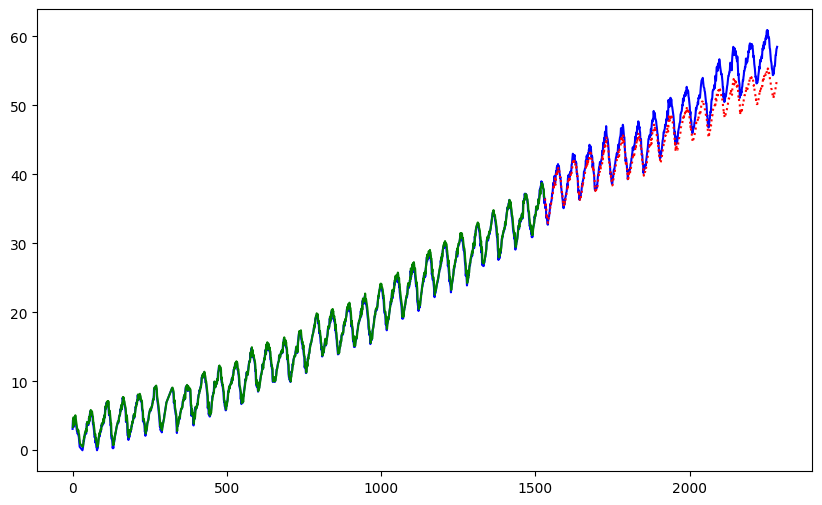

In [33]:
trainPredictPlot = np.empty_like(dataset_LSTM)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset_LSTM)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_LSTM)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(10, 6)) 
plt.plot(scaler.inverse_transform(dataset_LSTM), color='blue')
plt.plot(trainPredictPlot, color='green')
plt.plot(testPredictPlot, linestyle=':',    color='red')
plt.savefig('pictures/Modellierung/LSTM.pdf')
plt.show()

In Blau sind hierbei die tatsächlichen Werte zu sehen. In grün sind die Vorhersagen, die auf Basis des train Daten gemacht wurde. Diese liegen ziemlich genau über dem blauen Graphen weshalb man hier fast nur den grünen sieht. In rot gepunktet, sind die Vorhergesagten Daten zu sehen, welche auf nicht zum Trainieren verwendet wurden. In beiden Fällen ist ein sehr gutes Ergebnis zu beobachten. Bei der roten Linie ist zu erkennen umsoweiter sie sich von den train Daten entfernen umso ungenauer werden sie. Dennoch auch gegen Ende noch sehr gute Werte zu erkennen. 